In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import jit, vmap, grad, value_and_grad, make_jaxpr
import jaxquantum as jqt 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import time

# Intro to JAX

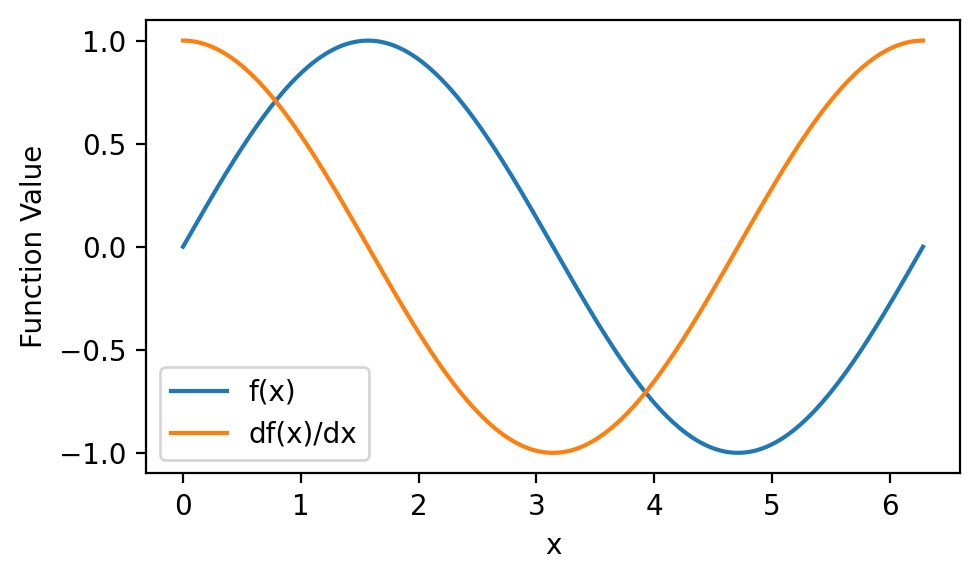

In [3]:
def f(x):
    return jnp.sin(x)

x = jnp.linspace(0, 2*jnp.pi, 1000)

df_dx = vmap(grad(f))


fig, ax = plt.subplots(1,1,dpi=200, figsize=(5,3))
ax.plot(x, f(x), label='f(x)')
ax.plot(x, df_dx(x), label='df(x)/dx')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('Function Value')
fig.tight_layout()

In [4]:
f_vmap_jit = jit(vmap(f))

%timeit -n1 -r1 f_vmap_jit(x)
%timeit f_vmap_jit(x)

12.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
19.5 µs ± 3.96 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [5]:
make_jaxpr(f_vmap_jit)

<function jax.make_jaxpr(f)(x)>

# Lossy Harmonic Oscillator

100% |██████████| [00:02<00:00, 37.21%/s]


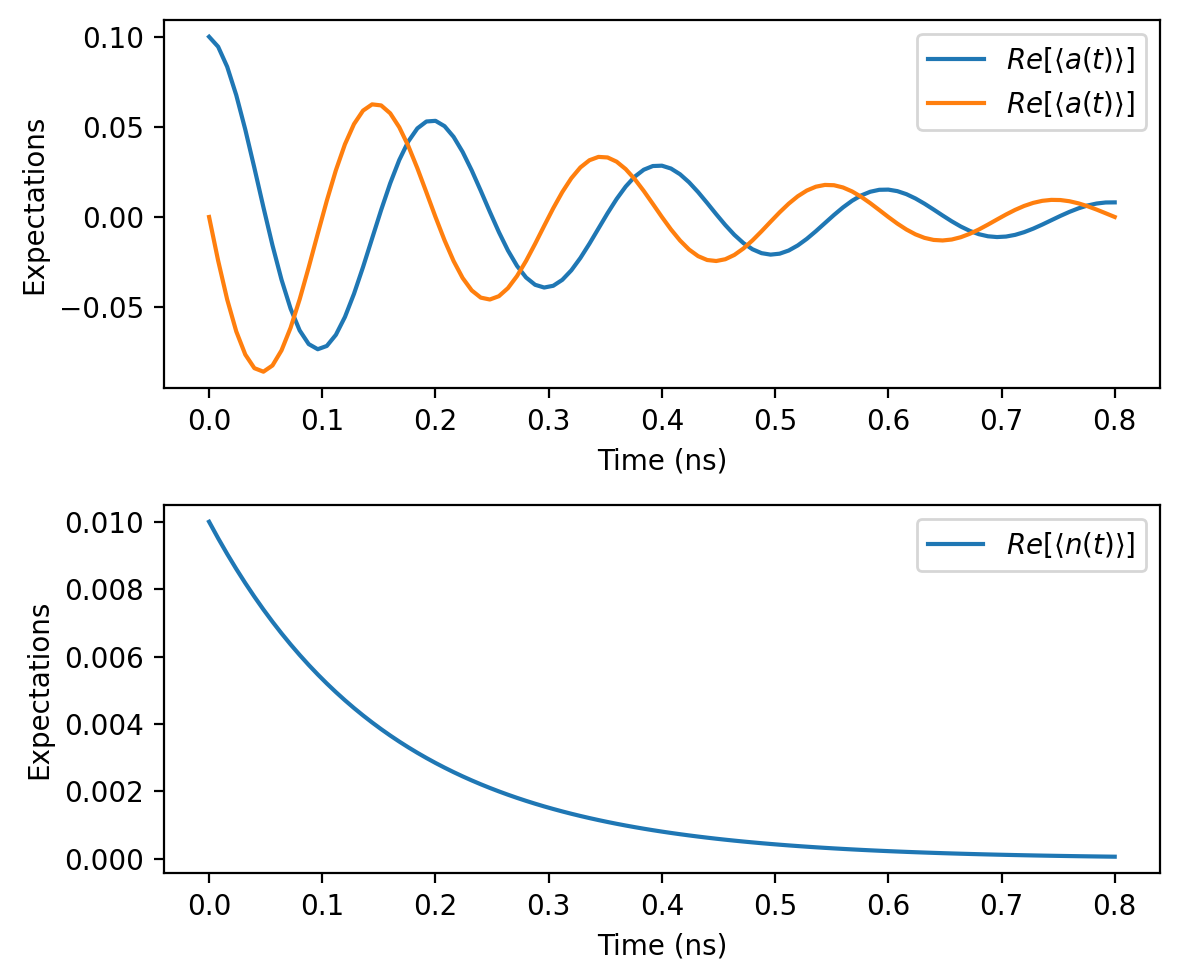

In [6]:
N = 100

omega_a = 2.0*jnp.pi*5.0
kappa = 2*jnp.pi*1
initial_state = jqt.displace(N, 0.1) @ jqt.basis(N,0)
initial_state_dm = initial_state.to_dm()
ts = jnp.linspace(0, 4*2*jnp.pi/omega_a, 101)

a = jqt.destroy(N)
n = a.dag() @ a

c_ops = [a*jnp.sqrt(kappa)]

@jit
def Ht(t):
    H0 = omega_a*n
    return H0

solver_options = jqt.SolverOptions.create(progress_meter=True)
states = jqt.mesolve(initial_state_dm, ts, c_ops=c_ops, Ht=Ht, solver_options=solver_options) 
nt = jnp.real(jqt.calc_expect(n, states))
a_real = jnp.real(jqt.calc_expect(a, states))
a_imag = jnp.imag(jqt.calc_expect(a, states))

fig, axs = plt.subplots(2,1, dpi=200, figsize=(6,5))
ax = axs[0]
ax.plot(ts, a_real, label=r"$Re[\langle a(t)\rangle]$")
ax.plot(ts, a_imag, label=r"$Re[\langle a(t)\rangle]$")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Expectations")
ax.legend()

ax = axs[1]
ax.plot(ts, nt, label=r"$Re[\langle n(t)\rangle]$")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Expectations")
ax.legend()
fig.tight_layout()

# Time Rabi Chevron

#### QuTiP

/opt/miniconda3/envs/jax-framework/lib/python3.9/site-packages/qutip/core/coefficient.py:386: UserWarning: Both `cython` and `filelock` are required for compilation of string coefficents. Falling back on `eval`.
  warnings.warn(


Elapsed time: 3.03 s


Text(0, 0.5, 'Time (ns)')

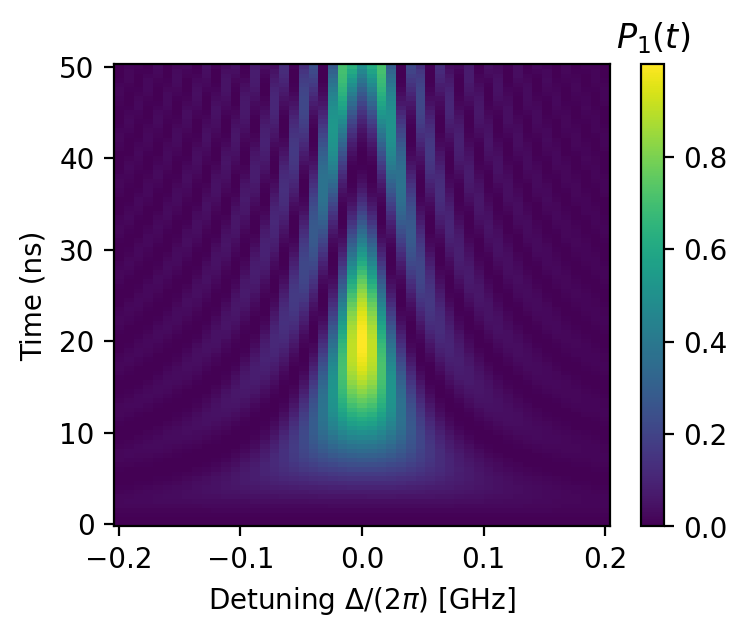

In [7]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt


g = qt.basis(2,0)
e = qt.basis(2,1)
initial_state = g
omega_q = 2*np.pi*1
Omega = 2*np.pi*0.05
sigmax = qt.sigmax()
sigmaz = qt.sigmaz()
H0 = omega_q/2 * sigmaz
H1 = Omega/2 * sigmax
ts = np.linspace(0,50, 101)

P_0 = np.zeros((51,101))
P_1 = np.zeros((51,101))
deltas_GHz = np.linspace(-0.2,0.2,51)

stime = time.time()
for j, delta_GHz in enumerate(deltas_GHz):
  delta = 2*np.pi*delta_GHz
  omega = omega_q + delta
  H = [H0,[H1,f'cos({omega} * t)']]
  results = qt.sesolve(H, initial_state, ts)
  P_0[j,:] = np.array([np.abs(g.dag() @ state)**2 for state in results.states])
  P_1[j,:] = np.array([np.abs(e.dag() @ state)**2 for state in results.states])
etime = time.time()

print(f"Elapsed time: {etime-stime:.2f} s")

fig, ax = plt.subplots(1,1,dpi=200, figsize=(4,3))
p = ax.pcolormesh(deltas_GHz, ts, P_1.T)
cbar = plt.colorbar(p)
cbar.ax.set_title(r"$P_1(t)$")
ax.set_xlabel("Detuning $\Delta/(2\pi)$ [GHz]")
ax.set_ylabel("Time (ns)")

#### JAX

In [8]:
g = jqt.basis(2,0)
e = jqt.basis(2,1)
initial_state = g
omega_q = 2*np.pi*1
Omega = 2*np.pi*0.05

sigmax = jqt.sigmax()
sigmaz = jqt.sigmaz()
H0 = omega_q/2 * sigmaz
H1 = Omega/2 * sigmax

ts = jnp.linspace(0,50, 101)

P_0 = jnp.zeros((51,101))
P_1 = jnp.zeros((51,101))
deltas_GHz = jnp.linspace(-0.2,0.2,51)


def time_rabi_chevron(delta_GHz):
    delta = 2*np.pi*delta_GHz
    omega = omega_q + delta
    Ht = lambda t: H0 + H1 * jnp.cos(omega * t)
    solver_options = jqt.SolverOptions.create(progress_meter=False)
    states = jqt.sesolve(initial_state, ts, Ht=Ht, solver_options=solver_options) 
    P_1 = jnp.real(jqt.calc_expect(e @ e.dag(), states))
    return P_1

time_rabi_chevron_map = jit(vmap(time_rabi_chevron))

In [9]:
%timeit -n1 -r1 P_1s = time_rabi_chevron_map(deltas_GHz)
%timeit P_1s = time_rabi_chevron_map(deltas_GHz)

6.87 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
57.8 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Text(0, 0.5, 'Time (ns)')

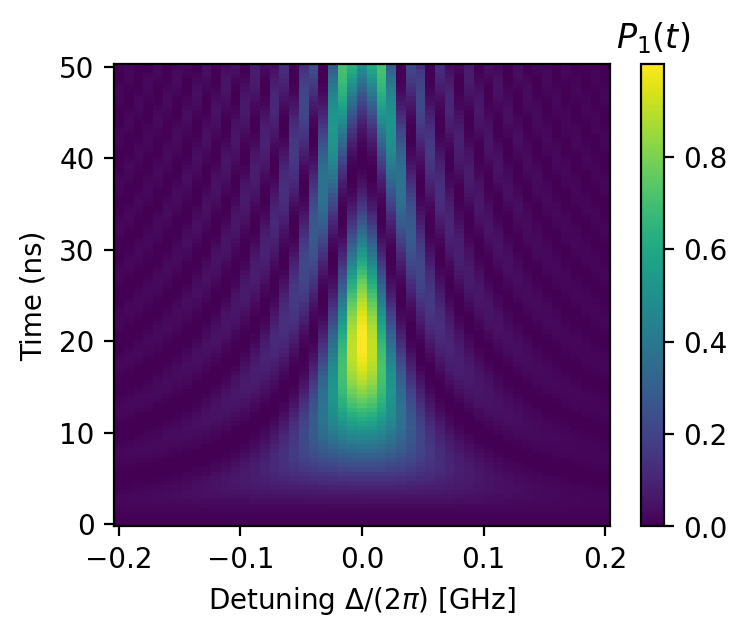

In [11]:
P_1s = time_rabi_chevron_map(deltas_GHz)
fig, ax = plt.subplots(1,1,dpi=200, figsize=(4,3))
p = ax.pcolormesh(deltas_GHz, ts, P_1s.T)
cbar = plt.colorbar(p)
cbar.ax.set_title(r"$P_1(t)$")
ax.set_xlabel("Detuning $\Delta/(2\pi)$ [GHz]")
ax.set_ylabel("Time (ns)")

### JAX Optimization

In [13]:
import optax

In [115]:
g = jqt.basis(2,0)
e = jqt.basis(2,1)
initial_state = g
omega_q = 2*np.pi*1
Omega = 2*np.pi*0.05

sigmax = jqt.sigmax()
sigmaz = jqt.sigmaz()
H0 = omega_q/2 * sigmaz
H1 = Omega/2 * sigmax

P_0 = jnp.zeros((51,101))
P_1 = jnp.zeros((51,101))


def time_rabi_chevron(x):
    delta_kHz, t_final = x
    ts = jnp.linspace(0,t_final, 2)
    delta = 2*np.pi*delta_kHz*1e-6
    omega = omega_q + delta
    Ht = lambda t: H0 + H1 * jnp.cos(omega * t)
    solver_options = jqt.SolverOptions.create(progress_meter=False)
    states = jqt.sesolve(initial_state, ts, Ht=Ht, solver_options=solver_options) 
    P_1 = jnp.real(jqt.calc_expect(e @ e.dag(), states))
    return P_1[1]


def compute_loss(params):
    P1 = time_rabi_chevron(params)
    return 1.0 - P1

val_grad_compute_loss = jit(value_and_grad(compute_loss))

In [116]:
val_grad_compute_loss(jnp.array([0.0, 20.0]))

/opt/miniconda3/envs/jax-framework/lib/python3.9/site-packages/jax/_src/lax/lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/opt/miniconda3/envs/jax-framework/lib/python3.9/site-packages/jax/_src/lax/lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/opt/miniconda3/envs/jax-framework/lib/python3.9/site-packages/jax/_src/lax/lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/opt/miniconda3/envs/jax-framework/lib/python3.9/site-packages/jax/_src/lax/lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


(Array(4.91545131e-05, dtype=float64),
 Array([ 4.99019185e-07, -6.61703365e-06], dtype=float64))

In [119]:
# Define optimizer
lr = 1e-1
opt = optax.scale_by_lbfgs()

# Initialize optimization
w = jnp.array([0.0, 10.0])
state = opt.init(w)

# Run optimization
for i in range(100):
  v, g = val_grad_compute_loss(w)
  if i % 10 == 0:
    print(f'Iteration: {i}, Value:{v:.2e}')
  u, state = opt.update(g, state, w)
  w = w - lr * u


Iteration: 0, Value:5.00e-01
Iteration: 10, Value:4.80e-01
Iteration: 20, Value:4.80e-01
Iteration: 30, Value:4.80e-01
Iteration: 40, Value:4.80e-01
Iteration: 50, Value:4.80e-01
Iteration: 60, Value:4.80e-01
Iteration: 70, Value:4.80e-01
Iteration: 80, Value:4.80e-01
Iteration: 90, Value:4.80e-01


In [120]:
params

Array([-0.42154236, 19.98160891], dtype=float64)

In [85]:
start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

params = jnp.array([0.0, 20])
opt_state = optimizer.init(params)

for _ in range(10000):
  grads = grad_compute_loss(params)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

In [86]:
compute_loss(params), params

(Array(0.99468542, dtype=float64),
 Array([-0.42154236, 19.98160891], dtype=float64))

In [87]:
compute_loss([0,20])

Array(4.91545131e-05, dtype=float64)